In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
import art
import asyncio
from dotenv import load_dotenv
import json
import openai
import random
import re
from typing import TypedDict

load_dotenv()


class TemporalCluePuzzle(TypedDict):
    num_clues: int
    prompt: str
    solution: dict[str, str]


puzzles: list[TemporalCluePuzzle] = json.load(open("./data/temporal-clue/puzzles.json"))
val_puzzles = puzzles[:64]
test_puzzles = puzzles[64:128]
train_puzzles = puzzles[128:]
random.seed(42)
random.shuffle(train_puzzles)


api = art.UnslothAPI(wandb_project="agent-reinforcement-training")
model = await api.get_or_create_model(
    name="temporal-clue-unsloth-001",
    base_model="unsloth/Qwen2.5-14B-Instruct",
)


async def rollout(
    client: openai.AsyncOpenAI, puzzle: TemporalCluePuzzle
) -> art.Trajectory:
    messages: art.Messages = [{"role": "user", "content": puzzle["prompt"]}]
    chat_completion = await client.chat.completions.create(
        messages=messages, model=model.name
    )
    choice = chat_completion.choices[0]
    content = choice.message.content
    assert isinstance(content, str)
    num_correct = 0
    for key, value in puzzle["solution"].items():
        if matches := re.findall(rf"{key}\. ([A-Za-z \.:-]+)", content):
            match = matches[-1]
            if match.strip().lower() == value.lower():
                num_correct += 1
    reward = acc = num_correct / len(puzzle["solution"])
    return art.Trajectory(
        messages_and_choices=[*messages, choice], reward=reward, metrics={"acc": acc}
    )


stride = 1
for i in range(await model.get_iteration(), 1_000):
    async with model.openai_client(
        estimated_completion_tokens=900, verbosity=2
    ) as openai_client:
        val_groups, train_groups = await asyncio.gather(
            art.gather_groups(
                (
                    (rollout(openai_client, puzzle) for _ in range(2))
                    for puzzle in val_puzzles[:1]
                ),
                pbar_desc="val",
                stream_chat_completions=8,
            ),
            art.gather_groups(
                (
                    (rollout(openai_client, puzzle) for _ in range(50))
                    for puzzle in train_puzzles[i * stride : (i + 1) * stride]
                ),
                pbar_desc="train",
            ),
        )
    await model.log(val_groups)
    await model.clear_iterations()
    await model.tune(
        train_groups, config=art.TuneConfig(plot_tensors=True, verbosity=2)
    )

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.15: Fast Qwen2 patching. Transformers: 4.49.0. vLLM: 0.7.3.
   \\   /|    NVIDIA H100 PCIe. Num GPUs = 1. Max memory: 79.19 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen2.5-14b-instruct-unsloth-bnb-4bit with actual GPU utilization = 59.6%
Unsloth: Your GPU has CUDA compute capability 9.0 with VRAM = 79.19 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 8192. Num Sequences = 320.
Unsloth: vLLM's KV Cache can use up to 36.35 GB. Also swap space = 6 GB.
Unsloth: vLLM Bitsandbytes config using kwargs

[W319 21:59:04.533750564 CUDAAllocatorConfig.h:28] Warning: expandable_segments not supported on this platform (function operator())


Loading safetensors checkpoint shards:   0% Completed | 0/3 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/3 [00:00<?, ?it/s]


Capturing CUDA graph shapes: 100%|██████████| 43/43 [00:41<00:00,  1.05it/s]
Unsloth 2025.3.15 patched 48 layers with 48 QKV layers, 48 O layers and 48 MLP layers.


val:   0%|          | 0/2 [00:00<?, ?it/s]

train:   0%|          | 0/50 [00:00<?, ?it/s]

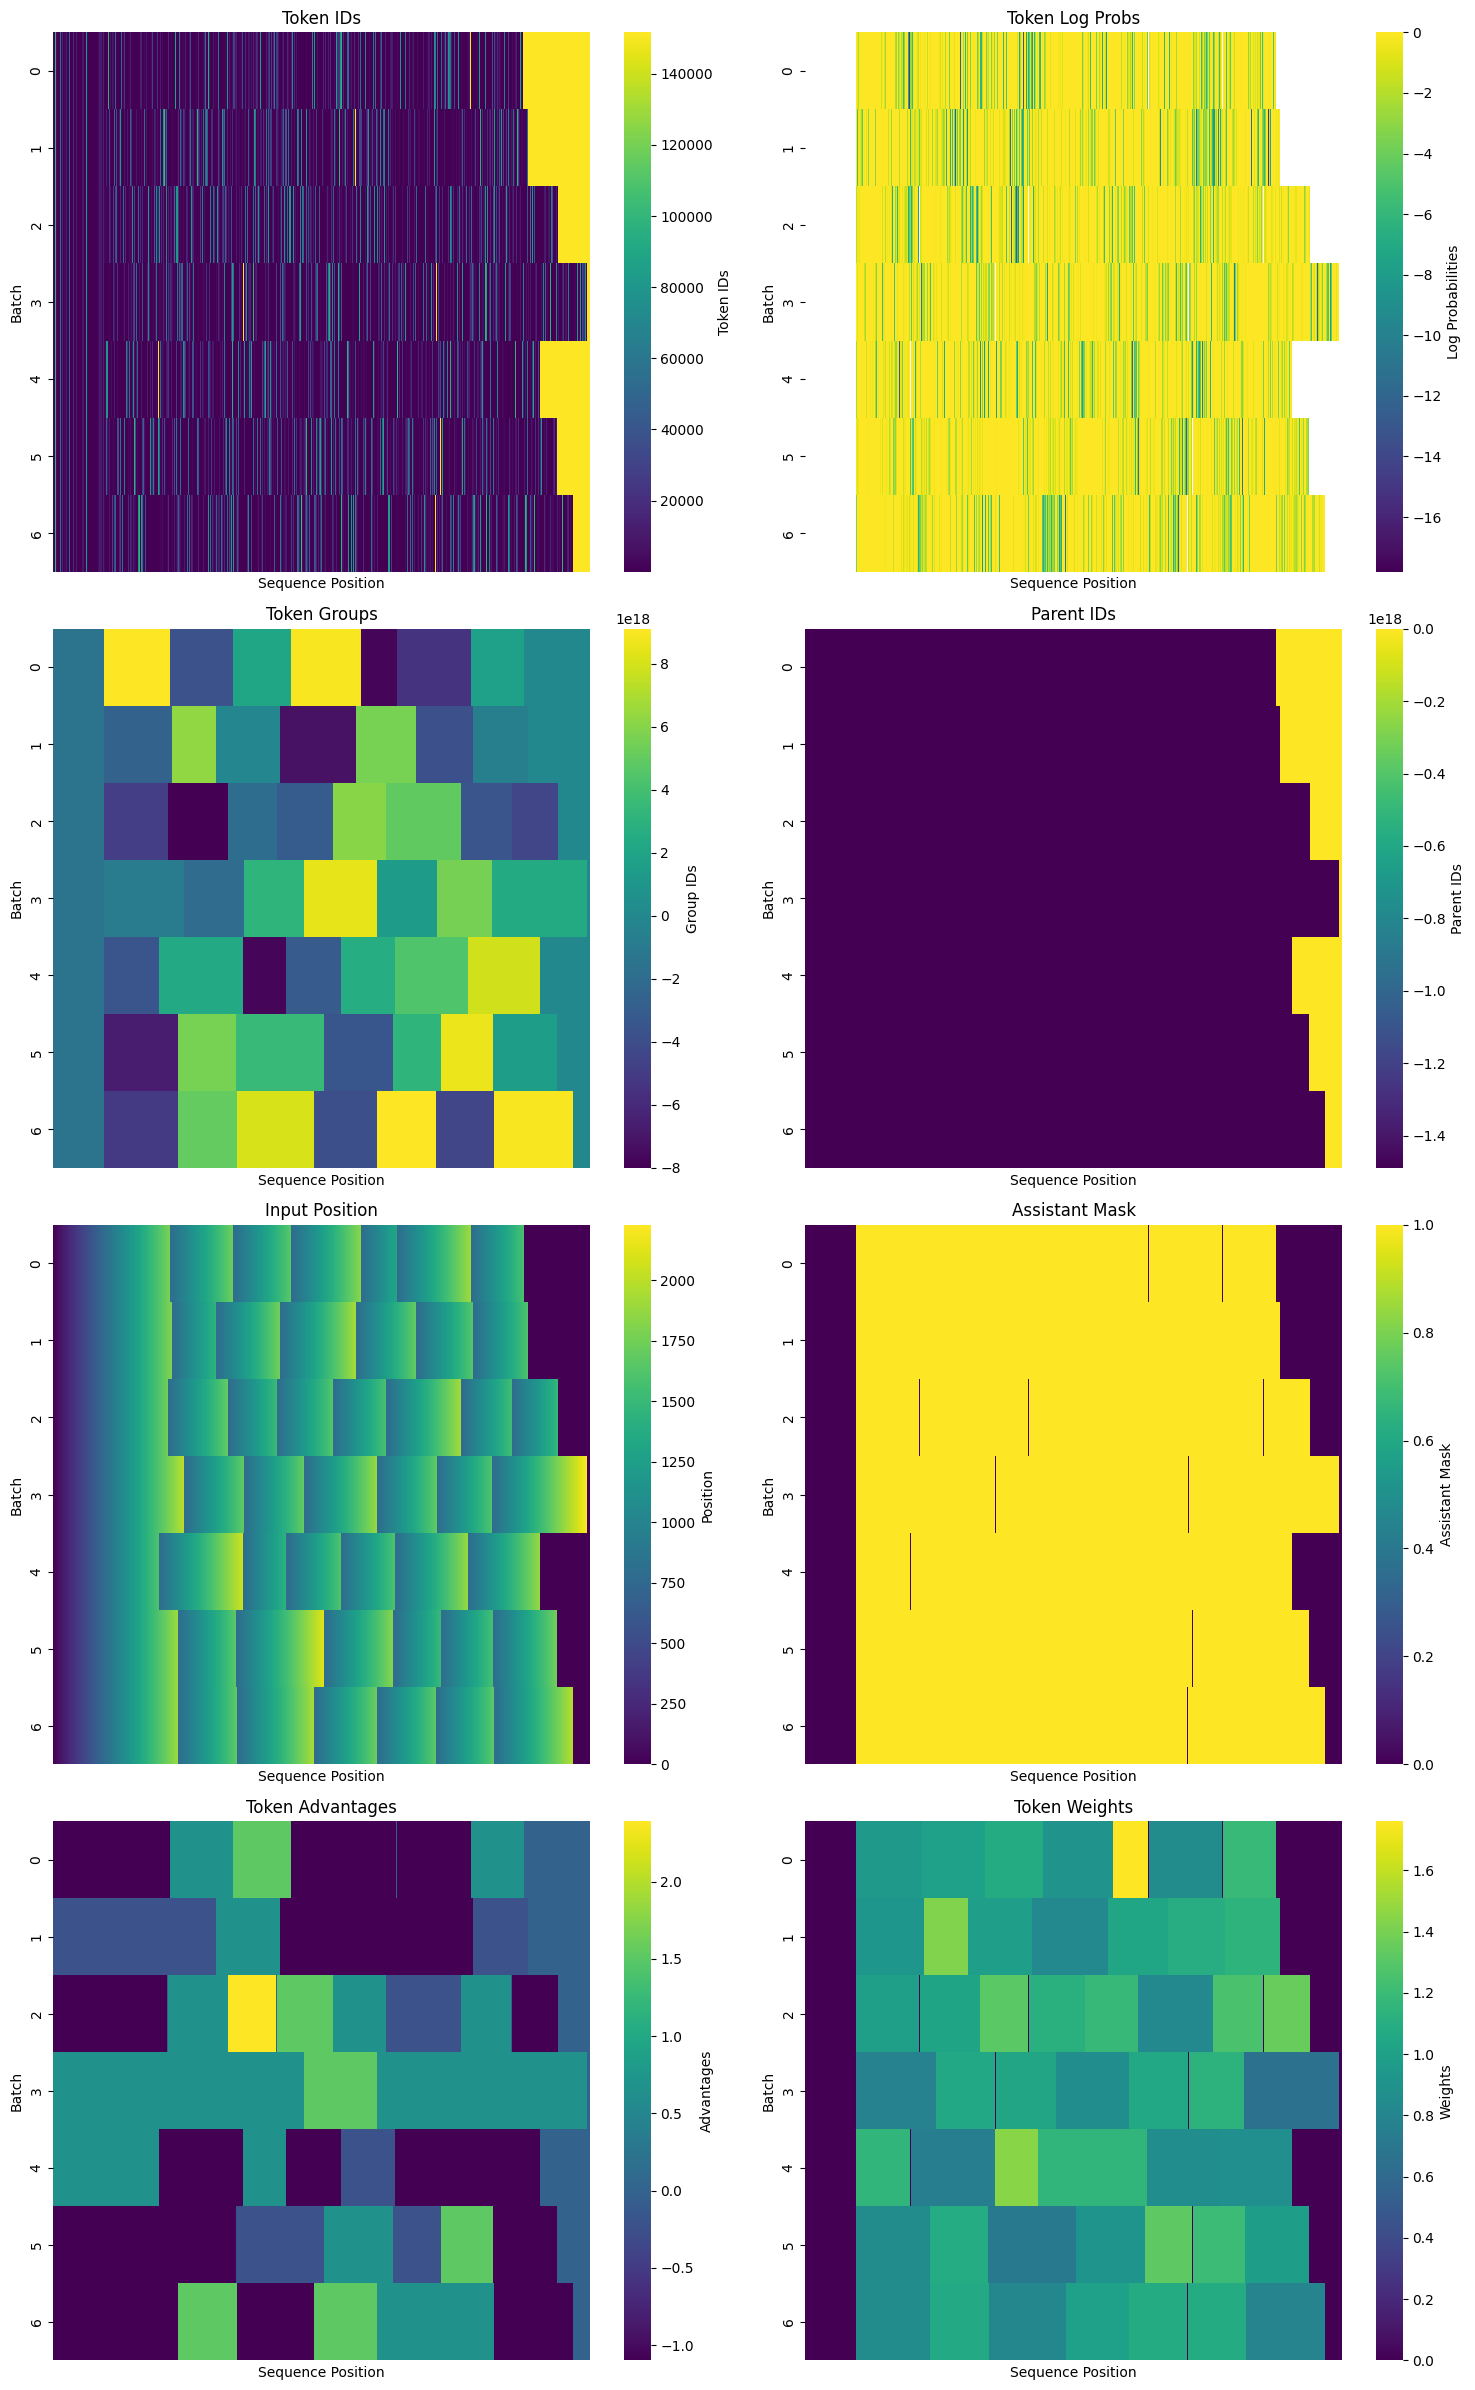

In [4]:
trainer = api._get_trainer(model)
packed_tensors = api._get_packed_tensors(model, train_groups, 8192, 2, True)

In [5]:
from art.unsloth.grpo import GRPO
import os
import torch

loss_fn = GRPO()
loss_fn._forward_chunk = torch.compile(
    loss_fn._forward_chunk,
    backend=os.environ.get("TORCH_COMPILE_BACKEND", "inductor"),
)

In [ ]:
from art.unsloth.pack import PackedTensors
from transformers import PreTrainedModel


def compute_loss(
    model: PreTrainedModel,
    inputs: PackedTensors,
    return_outputs: bool = False,
    num_items_in_batch: int | None = None,
) -> torch.Tensor:
    try:
        # Move tensors to the correct device
        inputs = {key: tensor.to(trainer.accelerator.device) for key, tensor in inputs.items()}  # type: ignore

        # Assume the first token in the batch is the bos token
        bos_id = int(inputs["tokens"].view(-1)[0].item())

        # Create grouped causal mask
        batch_size, seq_len = inputs["tokens"].size()
        causal_mask = (
            torch.tril(
                torch.ones(
                    seq_len,
                    seq_len,
                    dtype=torch.bool,
                    device=trainer.accelerator.device,
                )
            )
            .unsqueeze(0)
            .expand(batch_size, seq_len, seq_len)
        )
        group_mask = inputs["group_ids"].unsqueeze(2) == inputs["group_ids"].unsqueeze(
            1
        )
        parent_mask = inputs["parent_ids"].unsqueeze(2) == inputs[
            "group_ids"
        ].unsqueeze(1)
        mask = causal_mask & (group_mask | parent_mask)
        attn_bias = torch.where(mask, 0.0, float("-inf"))

        if not hasattr(trainer, "_autocast_dtype"):
            trainer._autocast_dtype = (
                torch.float16
                if os.environ.get("ACCELERATE_MIXED_PRECISION", "fp16") == "fp16"
                else torch.bfloat16
            )
            if os.environ.get("UNSLOTH_FORCE_FLOAT32", "0") == "1":
                trainer._autocast_dtype = torch.float16

        with torch.amp.autocast_mode.autocast(
            device_type="cuda", dtype=trainer._autocast_dtype
        ):
            logits = model(input_ids=inputs["tokens"], causal_mask=attn_bias).logits

        result = loss_fn.forward(
            logits=logits,
            tokens=inputs["tokens"],
            advantages=inputs["advantages"],
            logprobs=inputs["logprobs"],
            reference_logprobs=None,
            mask=inputs["assistant_mask"],
            weights=inputs["weights"],
            bos_id=bos_id,
        )
        return result.per_token().total_loss
    finally:
        for tensor in inputs.values():
            tensor.to("cpu")
        torch.cuda.empty_cache()


async def train() -> None:
    _compute_loss = trainer.compute_loss
    trainer.compute_loss = compute_loss
    try:
        trainer.train()
    finally:
        trainer.compute_loss = _compute_loss


task = asyncio.create_task(train())
for i in range(packed_tensors["tokens"].shape[0]):
    api._packed_tensors_queue.put_nowait(
        {key: tensor[i : i + 1] for key, tensor in packed_tensors.items()}  # type: ignore
    )
await asyncio.wait([task], timeout=60.0)
task.cancel()
task.result()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 100 | Num Epochs = 3 | Total steps = 250
O^O/ \_/ \    Batch size per device = 5 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (5 x 1 x 1) = 5
 "-____-"     Trainable parameters = 137,625,600/14,000,000,000 (0.98% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,reward,reward_std,completion_length,kl,rewards / reward_func
1,0.539600,0,0,0,0,0
2,-0.247300,No Log,No Log,No Log,No Log,No Log
3,-0.655600,No Log,No Log,No Log,No Log,No Log
4,0.509000,No Log,No Log,No Log,No Log,No Log
5,0.254800,No Log,No Log,No Log,No Log,No Log


InvalidStateError: Result is not ready.

In [14]:
async with model.openai_client(
    estimated_completion_tokens=900, verbosity=2
) as openai_client:
    val_groups, train_groups = await asyncio.gather(
        art.gather_groups(
            (
                (rollout(openai_client, puzzle) for _ in range(2))
                for puzzle in val_puzzles
            ),
            pbar_desc="val",
            stream_chat_completions=8,
        ),
        art.gather_groups(
            (
                (rollout(openai_client, puzzle) for _ in range(50))
                for puzzle in train_puzzles[i * stride : (i + 1) * stride]
            ),
            pbar_desc="train",
        ),
    )

val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/50 [00:00<?, ?it/s]

ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-2651' coro=<listen_for_disconnect() done, defined at /home/ubuntu/sky_workdir/.venv/lib/python3.12/site-packages/vllm/entrypoints/utils.py:9> exception=UnboundLocalError("cannot access local variable 'message' where it is not associated with a value")>
Traceback (most recent call last):
  File "/home/ubuntu/sky_workdir/.venv/lib/python3.12/site-packages/anyio/_backends/_asyncio.py", line 743, in __aexit__
    await self._on_completed_fut
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/futures.py", line 289, in __await__
    yield self  # This tells Task to wait for completion.
    ^^^^^^^^^^
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/tasks.py", line 385, in __wakeup
    future.result()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/futures.py", lin

In [11]:
task.cancel()

True

In [13]:
# Clean up CUDA memory
import torch
import gc

# Empty CUDA cache
torch.cuda.empty_cache()

# Force garbage collection
gc.collect()

# # If you're using a model, you can move it to CPU to free GPU memory
# if 'model' in locals():
#     model.to('cpu')

# Print memory stats to verify cleanup
print(f"CUDA memory allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print(f"CUDA memory reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
print(f"CUDA memory free: {torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_reserved() / 1024**2:.2f} MB")

# # Optional: Set PyTorch to use expandable segments to avoid fragmentation
# import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


CUDA memory allocated: 49003.68 MB
CUDA memory reserved: 49362.00 MB
CUDA memory free: 85029109550.00 MB
